In [8]:
import os, gc
import numpy as np
import joblib
import matplotlib.pyplot as plt

#from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from matplotlib import colors
from yellowbrick.cluster import KElbowVisualizer

np.set_printoptions(suppress=True, precision = 3)

In [9]:
"""
DATA DESCRIPTION
Indicate the file names for the pre-processed data and for the tumor/non-tumor map. 
The pre-processed data is a list of dictionaries, one for each sample, each dictionary has the 2D x 1738 data
plus its methylation label, sample name, patient ID, , t-SNE and PCA decompositions (datastructure described below).
The tumor/non-tumor map is a list of numpy arrays, one for each sample, of the same 2D shape as the 
corresponding sample, coming in the same order as the samples in the pre-processed file. 
Each entry in the 2D array is 0/1, with 1 indicating that the corresponding spot in the pre-processed data 
was labeled as tumor. 
The map is to be used as filter: only those spot labeled as tumor are to be analysed further. 
We also use the map to extract the most discriminative features between tumor and non-tumor. 
"""

PREPROC_DATA_PATH = "../data/preprocessed.npy"
TUMOR_MAP_PATH = "../data/tumor_maps.npy"

BINARY_CLUSTER_PATH = "../data/BinaryClusters.job"
BINARY_CLUSTER_IMAGES_PATH = "../images/binary_cluster/"

SIX_CLUSTER_PATH = "../data/SixClusters.job"
SIX_CLUSTER_IMAGES_PATH = "../images/six_cluster/"

# Make the directory if it doesn't exist
if not os.path.exists(BINARY_CLUSTER_IMAGES_PATH[:-1]):
    os.mkdir(BINARY_CLUSTER_IMAGES_PATH[:-1])
    
for lgm in range(1,7):
    if not os.path.exists(BINARY_CLUSTER_IMAGES_PATH+"lgm"+str(lgm)):
        os.mkdir(BINARY_CLUSTER_IMAGES_PATH+"lgm"+str(lgm))

if not os.path.exists(SIX_CLUSTER_IMAGES_PATH[:-1]):
    os.mkdir(SIX_CLUSTER_IMAGES_PATH[:-1])

for lgm in range(1,7):
    if not os.path.exists(SIX_CLUSTER_IMAGES_PATH+"lgm"+str(lgm)):
        os.mkdir(SIX_CLUSTER_IMAGES_PATH+"lgm"+str(lgm))

SAMPLE_DICT_DATA_KEY = "data"
SAMPLE_DICT_NAME_KEY = "name"
SAMPLE_DICT_CLASS_ID_KEY = "class_id"
SAMPLE_DICT_PATIENT_ID_KEY = "patient_id"
SAMPLE_DICT_TSNE_KEY = "tsne"
SAMPLE_DICT_PCA_KEY = "pca"

RAMAN_FREQ_RANGE = []

# Define the samples to be excluded from the analysis (use their full name)
ignore = ["HF-1887_via-t_2_1.h5_3"]

In [10]:
"""
Setup for color consistency in figure plotting.
The first color is black, used to display non-tumor.
Normalization is needed due to the way imshow handles images.
"""

# Colors for binary cluster separation
bin_cols = ["black", "peru", "linen"]
bin_norm = colors.Normalize(vmin = 0, vmax = len(bin_cols)-1)
bin_cmap = colors.ListedColormap(bin_cols)

# Colors for six cluster separation
six_cols = ["black", "cyan", "purple", "yellow", "red", "green", "blue"]
six_norm = colors.Normalize(vmin = 0, vmax = len(six_cols)-1)
six_cmap = colors.ListedColormap(six_cols)

In [11]:
def reset_seed(SEED = 0):
    os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
reset_seed(2022)

In [12]:
# Read the pre-processed data and the tumor map of each sample. 
samples = np.load(PREPROC_DATA_PATH, allow_pickle=True)
tumor_map = np.load(TUMOR_MAP_PATH, allow_pickle=True)

# Save all spectra into the data for the model training, save its original shape
data = np.empty( (0, samples[0][SAMPLE_DICT_DATA_KEY].shape[2]) )

orig_shape=[]

remove_list = []
index = -1

for (sample, tumor) in zip(samples, tumor_map):
    index += 1
    # If the sample is in the ignore list, skip it
    if sample[SAMPLE_DICT_NAME_KEY] in ignore:
        remove_list.append(index)
        continue
        
    # Filter the data: retain only the tumor spots, based on the tumor map    
    # Simultaneously, flatten the data for the model training and save its original shape 
    orig_shape.append(sample[SAMPLE_DICT_DATA_KEY].shape)
    sample[SAMPLE_DICT_DATA_KEY] = sample[SAMPLE_DICT_DATA_KEY].reshape(-1, sample[SAMPLE_DICT_DATA_KEY].shape[2])
    tumor.resize(np.product(tumor.shape))
    data = np.append(data, sample[SAMPLE_DICT_DATA_KEY][tumor == 1], axis=0)    

samples_updated = np.delete(samples, remove_list)
tumor_map_updated = np.delete(tumor_map, remove_list)

del samples
del tumor_map
gc.collect()
samples = samples_updated
tumor_map = tumor_map_updated

In [13]:
# Create list of indices
shuffle = np.arange(len(data))
        
# Numpy shuffle method performs shuffle in place
np.random.shuffle(shuffle)

# Shuffle the data
data = np.squeeze(data[shuffle])

# Run k-elbow to find the optimal number of clusters for this dataset.

reset_seed(0)
kmeans = MiniBatchKMeans(
                     batch_size=4096,
                     n_init = 2000,
                     reassignment_ratio = 0.5,
                     max_iter = 500)

elb = KElbowVisualizer(kmeans, k=(2,15), metric = "silhouette")

elb.fit(np.squeeze(data[shuffle]))
elb.show()

In [14]:
# Run k-means with 2 clusters

reset_seed(2022)
model2 = MiniBatchKMeans(n_clusters = 2,
                     batch_size=4096,
                     n_init = 2000,
                     reassignment_ratio = 0.5,
                     max_iter = 2000,
                     random_state = 0)

# Train and fit the model
model2.fit(data)

# Save the model
joblib.dump(model2, BINARY_CLUSTER_PATH)

['../data/BinaryClusters.job']

HF-305_v4b_1_1.h5_6
[1785 4309]


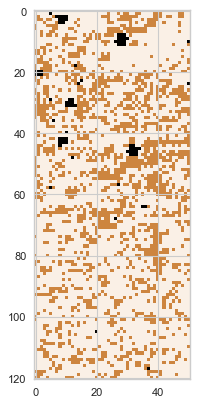

HF-442_V4BB_1.h5_12
[1603  445]


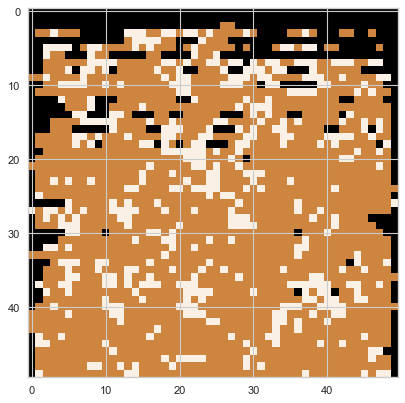

HF-448_V5B_1.h5_3
[3411    0]


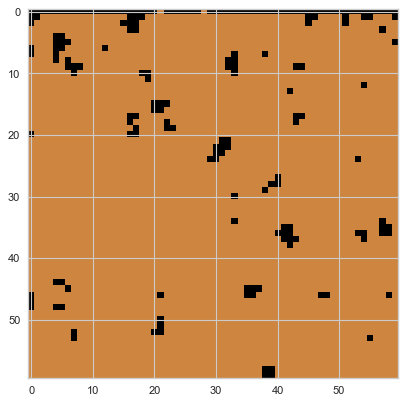

HF-592_V3T_1.h5_4
[ 862 2461]


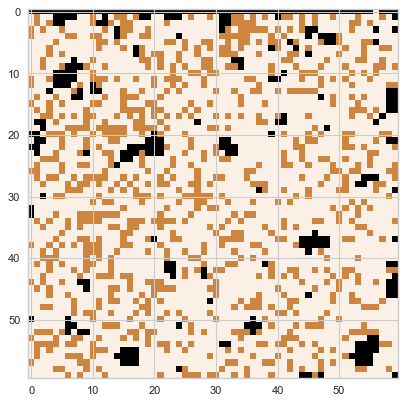

HF-615_V5BB_1.h5_9
[3185  108]


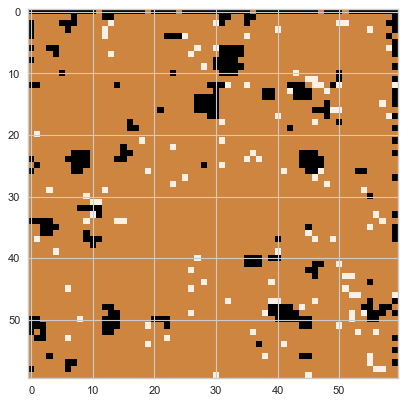

HF-682_V3AT_1.h5_9
[1437  381]


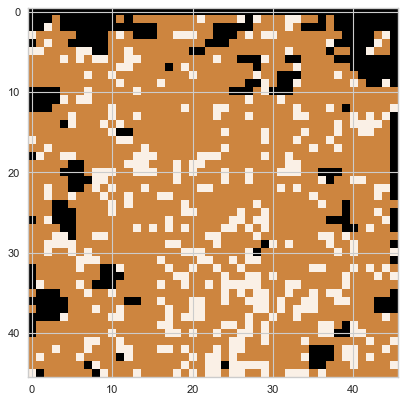

HF-682_V3BB_1.h5_10
[2744  607]


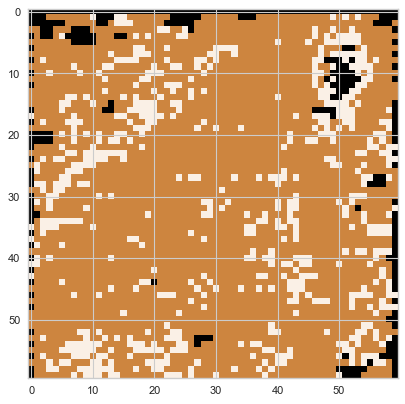

HF-868_1_2.h5_4
[   2 5301]


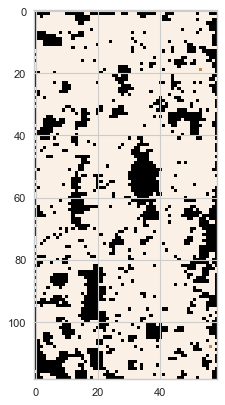

HF-894_9_1.h5_11
[  20 4718]


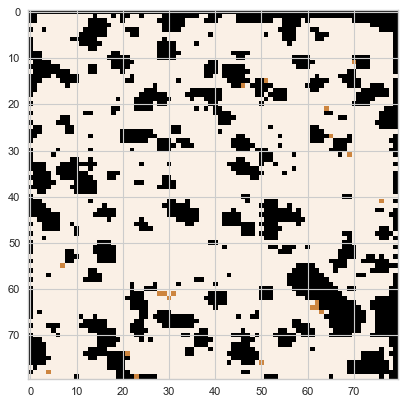

HF-894_V1BB_1.h5_12
[2021 1933]


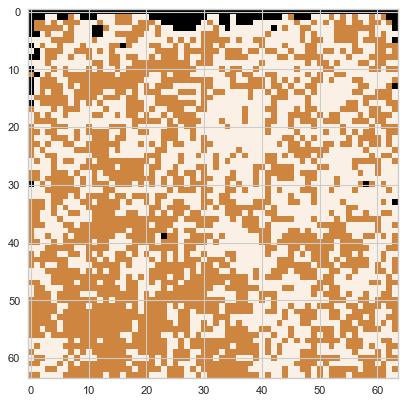

HF-901_V2T_2.h5_10
[5035 2159]


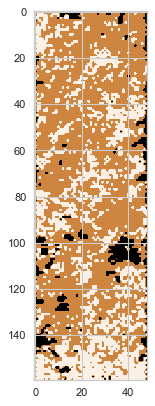

HF-960_VIAT_2.h5_11
[5810 2083]


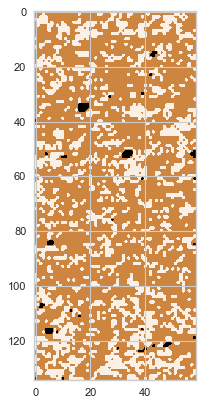

HF-988_V1-T_1.h5_13
[3476    0]


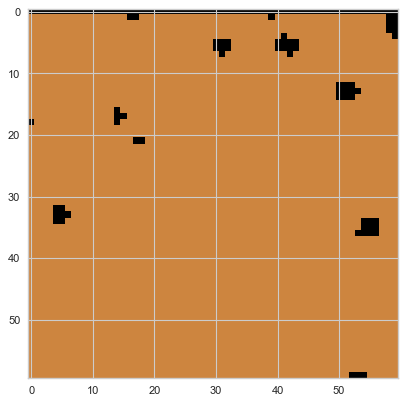

HF-988_V1B_1.h5_14
[2548 3831]


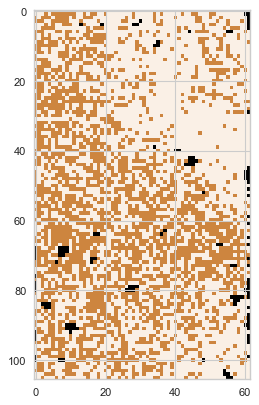

HF-1002_V1AT_1.h5_0
[2032 1105]


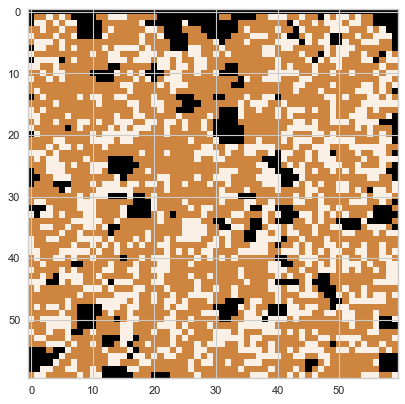

HF-1002_V2AT_1.h5_1
[1792 2302]


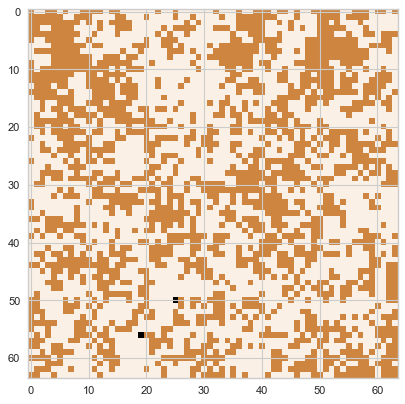

HF-1010_V1T_1.h5_0
[ 631 2713]


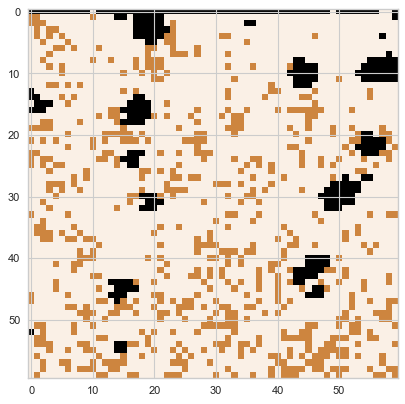

HF-1016_IAT_2.h5_1
[2269 4958]


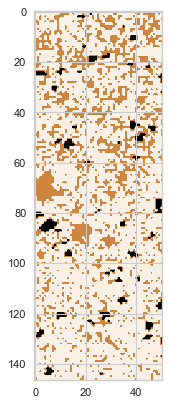

HF-1043_V1AM_1.h5_0
[2836 1232]


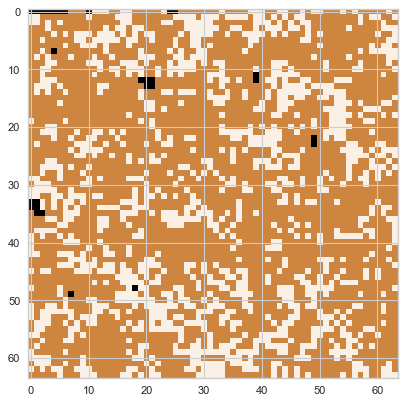

HF-1086_#1_1.h5_1
[1919  834]


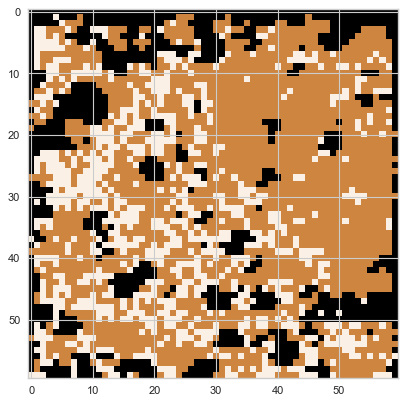

HF-1293_13_1.h5_0
[1624 4646]


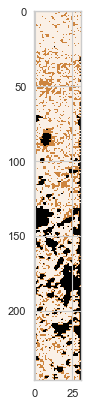

HF-1295_V3AM_2.h5_1
[ 3748 10716]


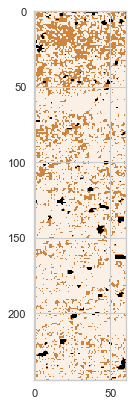

HF-1334_V58-B_2_1.h5_2
[6795    8]


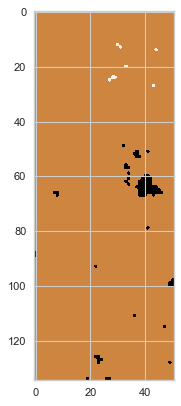

HF-1825_V2B_1.h5_2
[3546  490]


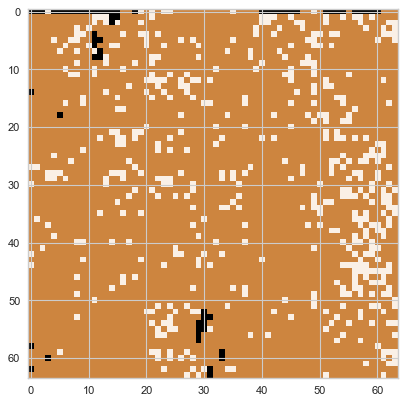

HF-2070_V1T_1.h5_4
[3557   43]


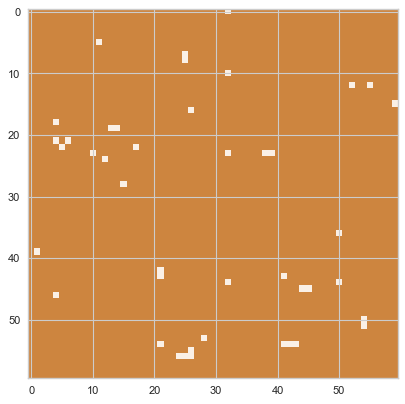

HF-2102_V2BB_1.h5_3
[3468    8]


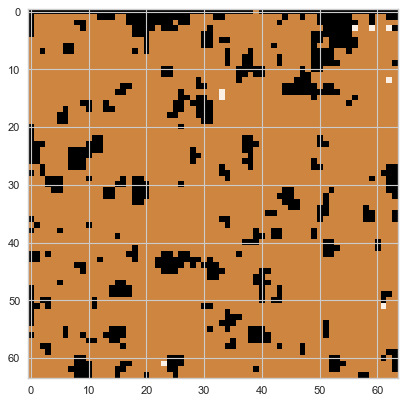

HF-2102_V3AM_1.h5_4
[1094 2200]


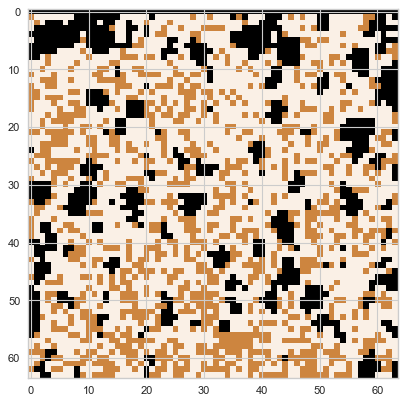

HF-2102_V3AM_2.h5_5
[1158 2105]


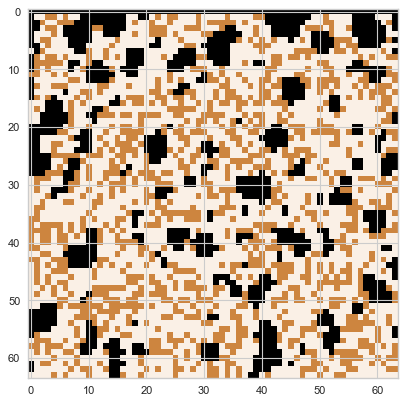

HF-2104_#5_1.h5_0
[1645 1837]


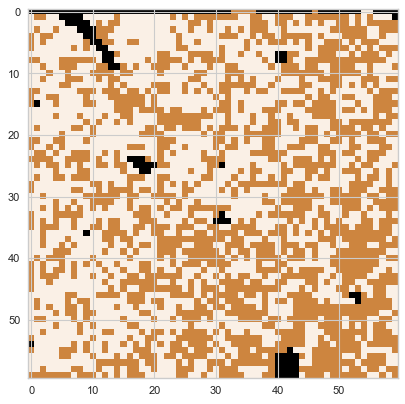

HF-2104_#9_1.h5_1
[1150 2713]


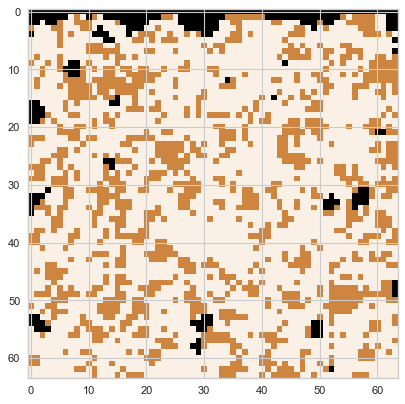

HF-2104_V1T_1.h5_2
[1636 1779]


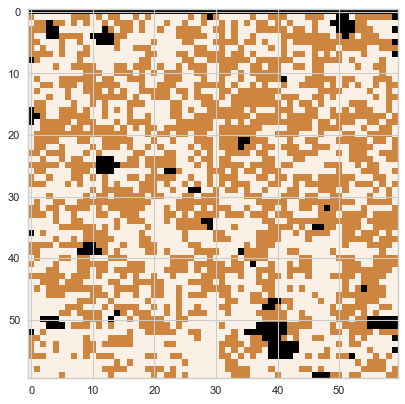

HF-2106_V3AM_1.h5_0
[2474 2423]


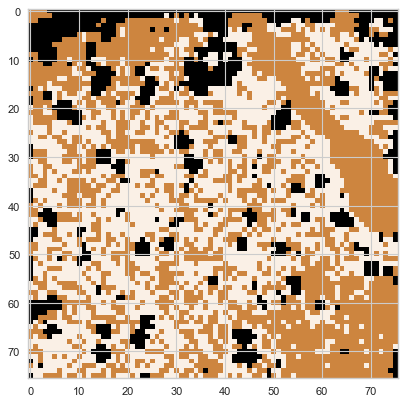

HF-2355_V2AM_1.h5_2
[3786  212]


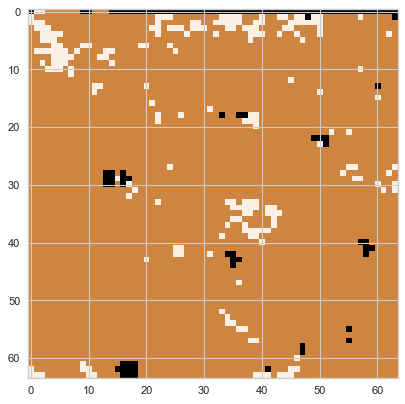

HF-2454_V1AT_1.h5_6
[3097  547]


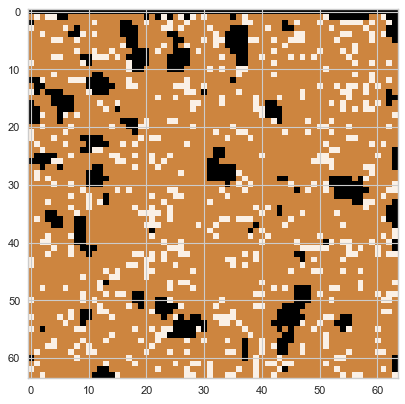

HF-2485_V1B_1.h5_3
[2558 1473]


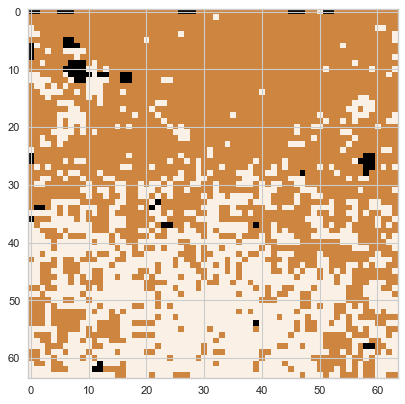

HF-2493_V1T_1.h5_1
[ 703 1971]


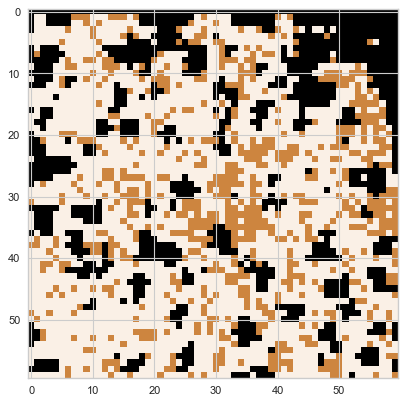

HF-2493_V1T_2.h5_2
[  12 1709]


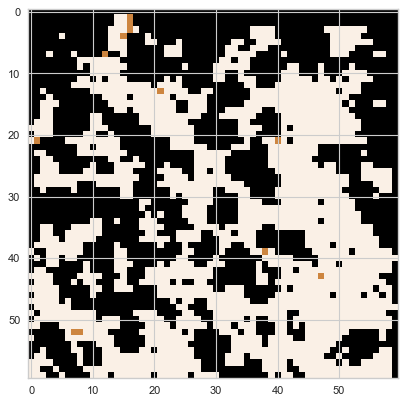

HF-2534_V2B_1.h5_2
[3845    3]


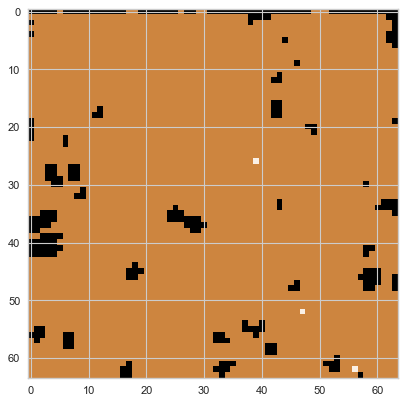

HF-2544_V1B_1.h5_3
[1115 1115]


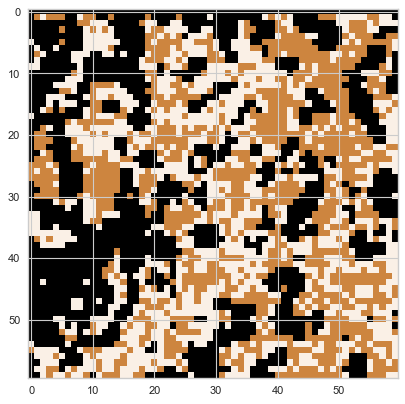

HF-2548_V1T_1.h5_7
[2374 1720]


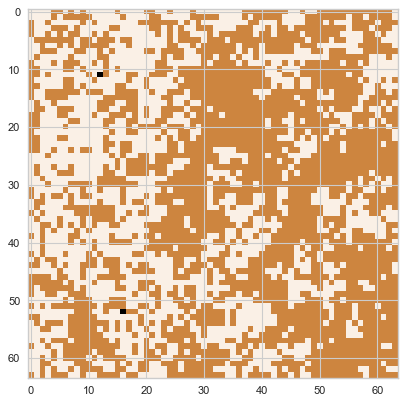

HF-2600_V1B_1.h5_4
[3662  270]


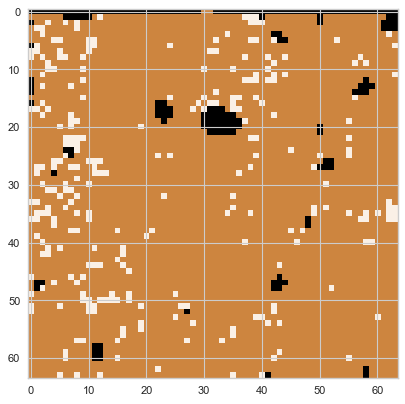

HF-2608_V1T_1.h5_5
[3153  741]


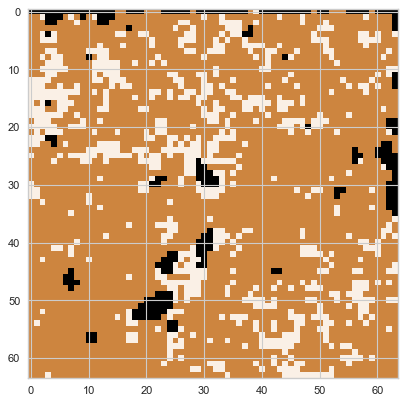

HF-2614_V1B_1.h5_3
[3316   69]


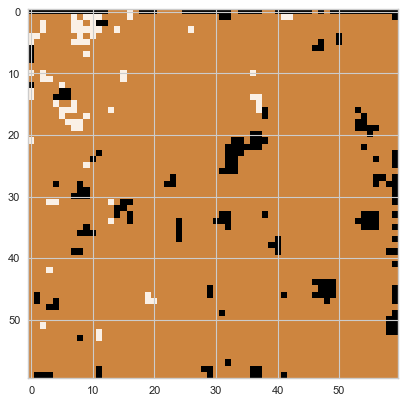

HF-2619_V1T_1.h5_6
[3958   68]


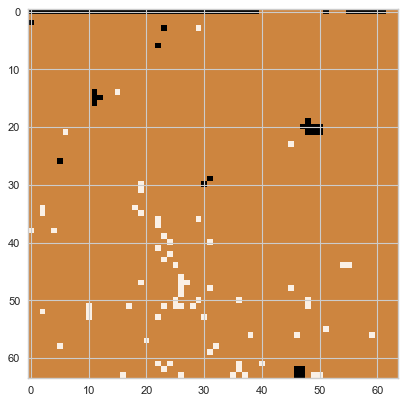

HF-2619_V4T_1.h5_7
[2654  861]


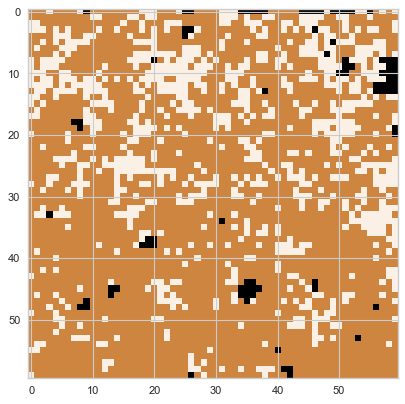

HF-2666_V2B_1.h5_8
[1462 2171]


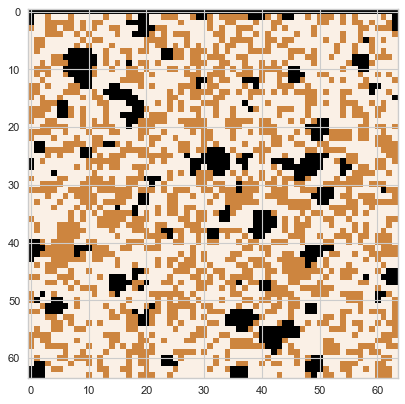

HF-2715_VIL_1.h5_8
[3375  671]


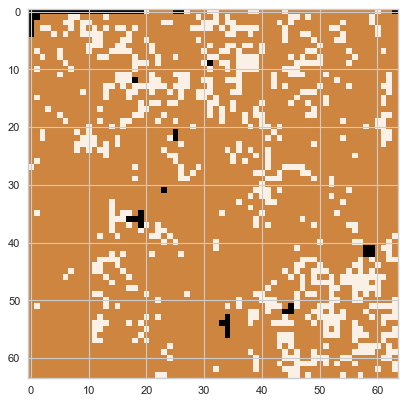

HF-2776_V2B_2.h5_5
[ 461 6839]


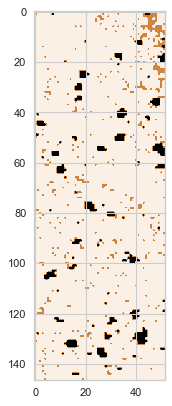

HF-2802_V3T_1.h5_9
[2572 1432]


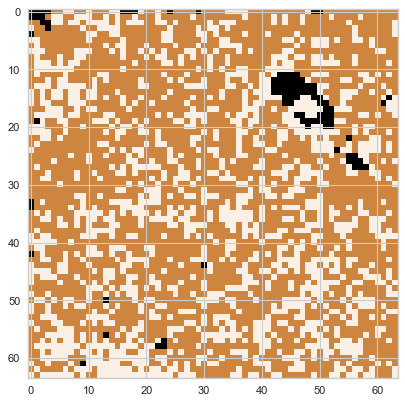

HF-2849_VIT2_1.h5_4
[ 427 1098]


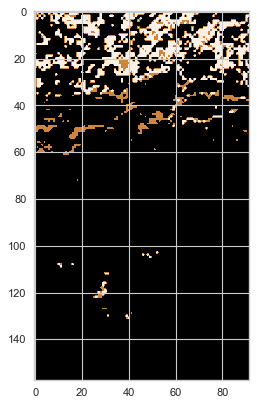

HF-2849_VIT2_1.h5_5
[2024 1606]


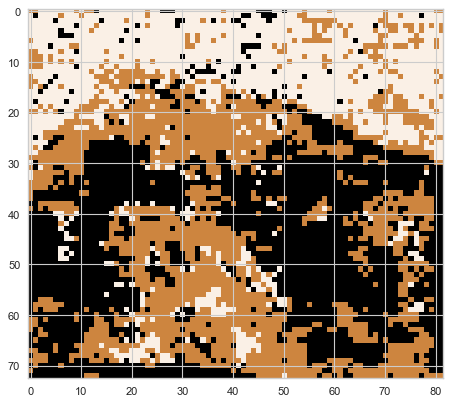

HF-2849_VIT2_2.h5_6
[2272 1566]


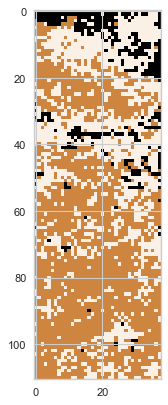

HF-2849_VIT_2_new2021.h5_7
[3775 1915]


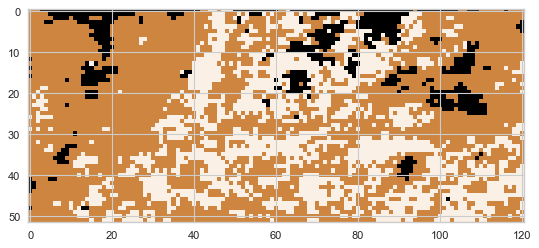

HF-2852_VIT_2_2.h5_8
[ 753 2913]


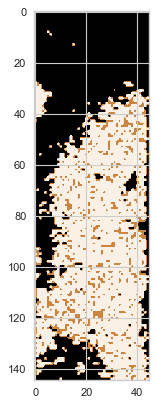

HF-2876_V1T_1.h5_10
[3382   60]


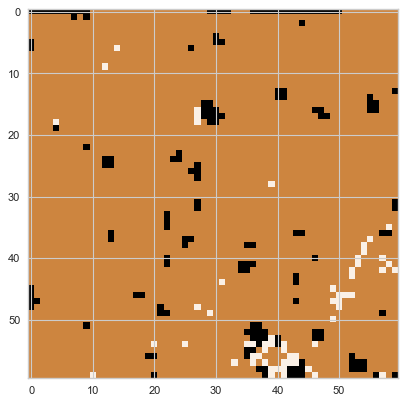

HF-2898_V1T_1.h5_11
[1145 2870]


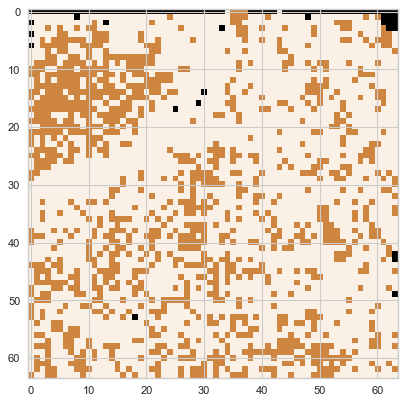

HF-3271_VIB_2.h5_7
[8340 3692]


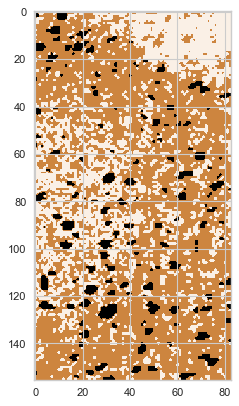

HF-3337_V3T_1.h5_8
[1075 2959]


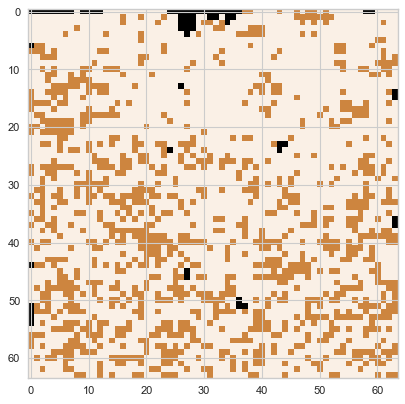

In [15]:
"""
Compute and save the surface map of each sample.
"""
   
# For each sample, display the surface map with the non-tumor spots as black.
for (sample, tumor, shape) in zip(samples, tumor_map, orig_shape):
    # If the sample is in the ignore list, skip it
    if sample[SAMPLE_DICT_NAME_KEY] in ignore:
        continue
        
    print(sample[SAMPLE_DICT_NAME_KEY])
    
    # Fill the predictions with 0; the tumor spots get their values replaced with the cluster ID (1 or larger)
    predict = np.zeros(tumor.shape, dtype=int)
    predict[tumor == 1] = 1 + model2.predict(sample[SAMPLE_DICT_DATA_KEY][tumor == 1])
    
    # Print the frequency of cluster predictions
    print(np.bincount(predict[tumor == 1]-1, minlength=2))

    # Bigger picture for better resolution
    plt.figure(figsize=(8, 6), dpi=80)
    
    # Use the cmap and norm defined in the beginning of the script
    plt.imshow(predict.reshape((shape[0],shape[1])), cmap = bin_cmap, norm = bin_norm)
    plt.savefig(BINARY_CLUSTER_IMAGES_PATH+"lgm"+str(sample[SAMPLE_DICT_CLASS_ID_KEY])+"/"+sample[SAMPLE_DICT_NAME_KEY]+".png")
    plt.show()

In [16]:
# See how many spectra are within each cluster
print(np.bincount(model2.predict(data)))

[142609 110999]


In [17]:
del model2
gc.collect()

51128

# Six clusters

In [18]:
# Run k-means with 6 clusters

reset_seed(2022)
model6 = MiniBatchKMeans(n_clusters=6,
                     batch_size=4096,
                     n_init = 2000,
                     reassignment_ratio = 0.5,
                     max_iter = 2000,
                     random_state = 0)

model6.fit(data)

# Save the model
joblib.dump(model6, SIX_CLUSTER_PATH)

['../data/SixClusters.job']

HF-305_v4b_1_1.h5_6
[ 996    0    2 4979    0  117]


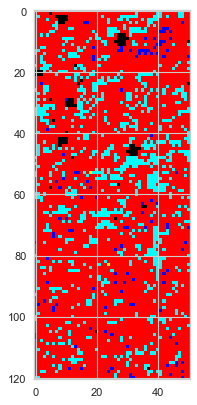

HF-442_V4BB_1.h5_12
[1232    0   60  687   68    1]


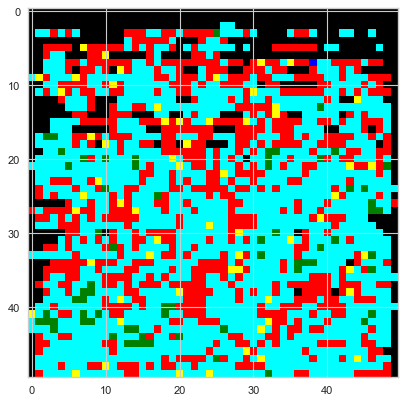

HF-448_V5B_1.h5_3
[2747  576    0    3   85    0]


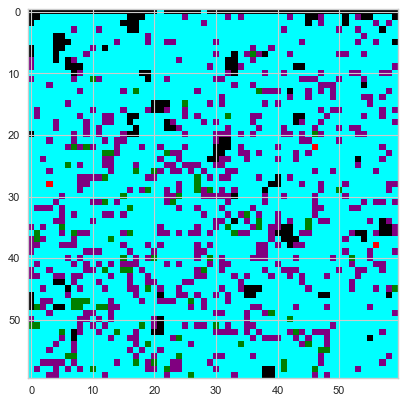

HF-592_V3T_1.h5_4
[ 393    0    0 2900    1   29]


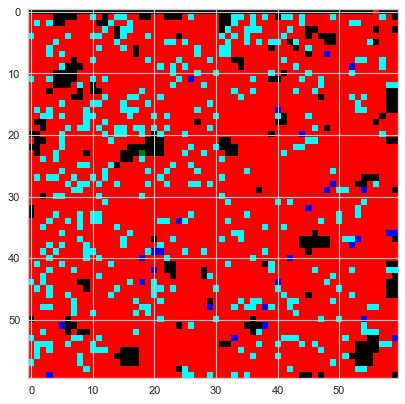

HF-615_V5BB_1.h5_9
[2675    0    2  352  264    0]


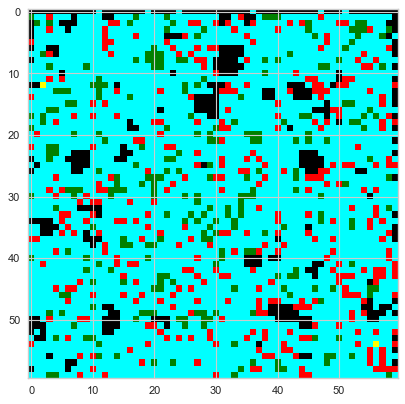

HF-682_V3AT_1.h5_9
[1097    0   67  653    1    0]


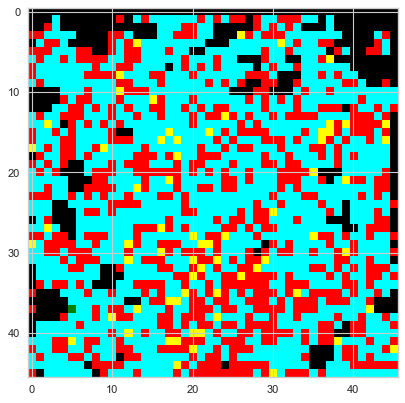

HF-682_V3BB_1.h5_10
[2163    0   83 1059   46    0]


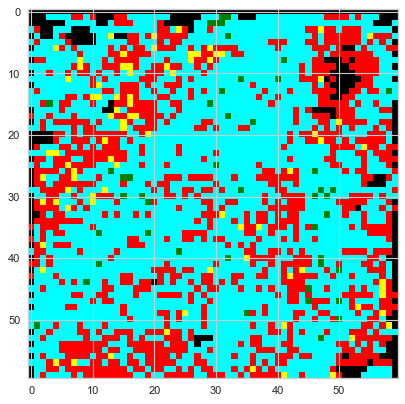

HF-868_1_2.h5_4
[   0    0    0  649    0 4654]


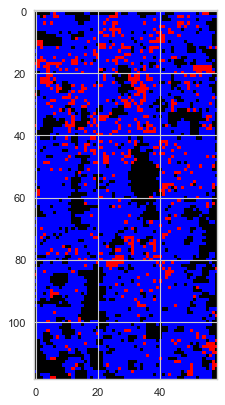

HF-894_9_1.h5_11
[   9    0    4 2874    1 1850]


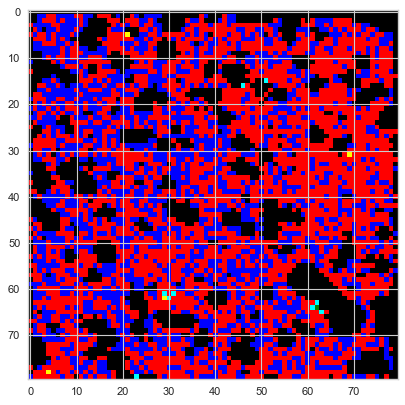

HF-894_V1BB_1.h5_12
[1322    3    0 2619    4    6]


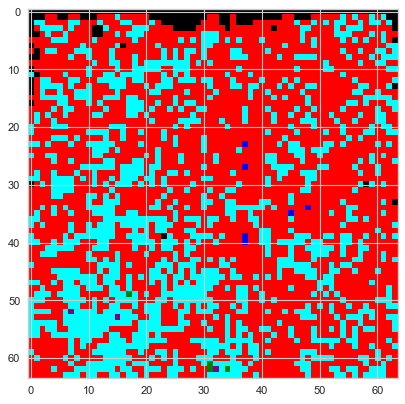

HF-901_V2T_2.h5_10
[3732    7    6 3416    2   31]


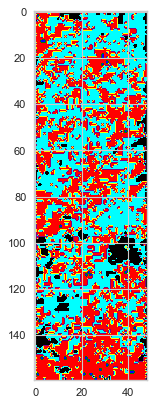

HF-960_VIAT_2.h5_11
[4230    2    5 3655    0    1]


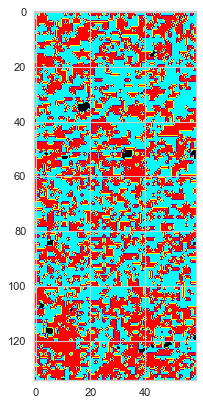

HF-988_V1-T_1.h5_13
[   7    0    0    0 3469    0]


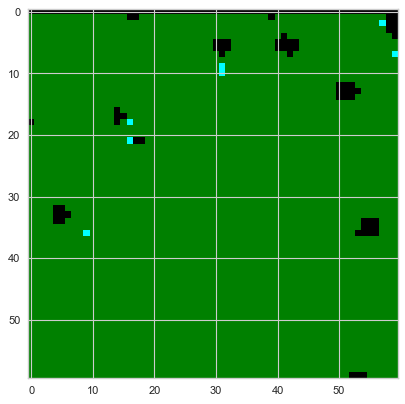

HF-988_V1B_1.h5_14
[1545    0  104 4670    0   60]


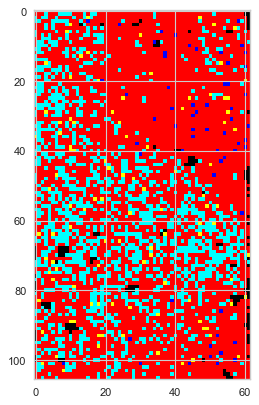

HF-1002_V1AT_1.h5_0
[1385    0  238 1499   14    1]


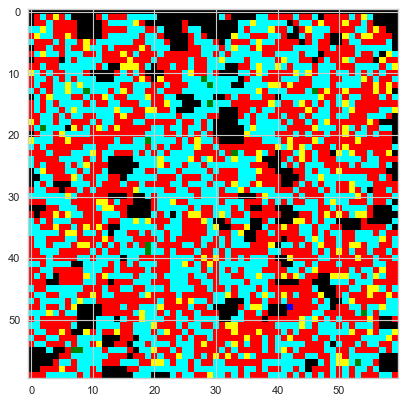

HF-1002_V2AT_1.h5_1
[1158    2    0 2902    6   26]


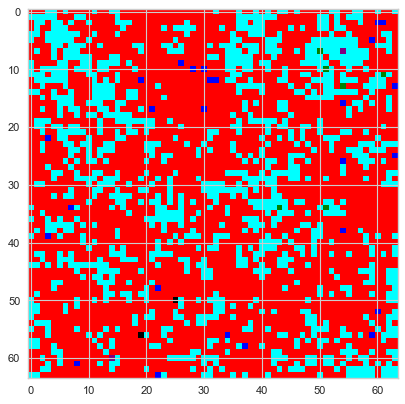

HF-1010_V1T_1.h5_0
[ 165    0   37 3089    0   53]


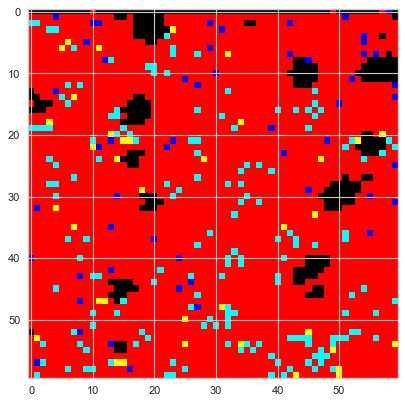

HF-1016_IAT_2.h5_1
[1036    9    0 6150   12   20]


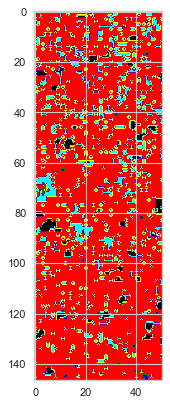

HF-1043_V1AM_1.h5_0
[2225   26    0 1789   24    4]


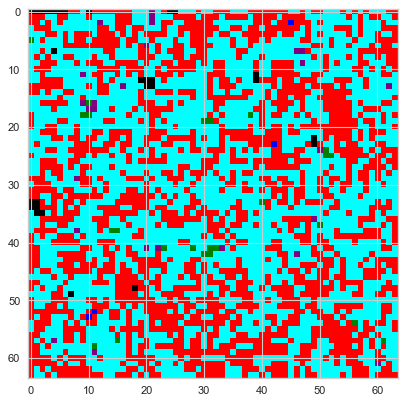

HF-1086_#1_1.h5_1
[1354    0  210 1078  107    4]


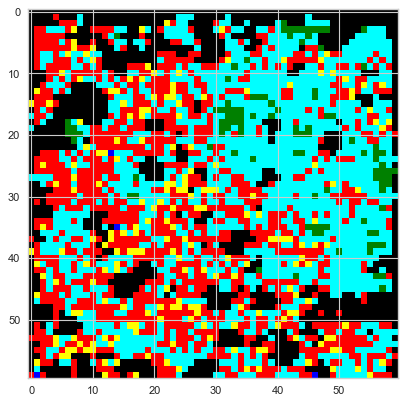

HF-1293_13_1.h5_0
[ 880    0    0 5192    0  198]


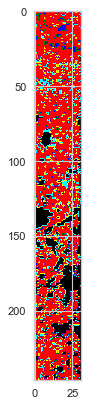

HF-1295_V3AM_2.h5_1
[ 1886     0     0 12127     0   451]


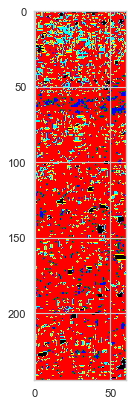

HF-1334_V58-B_2_1.h5_2
[4002  109    0   28 2664    0]


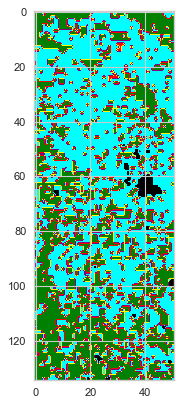

HF-1825_V2B_1.h5_2
[2953   15    0 1051   17    0]


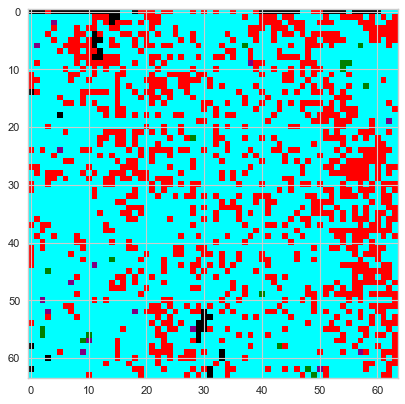

HF-2070_V1T_1.h5_4
[1838    0    2  126 1634    0]


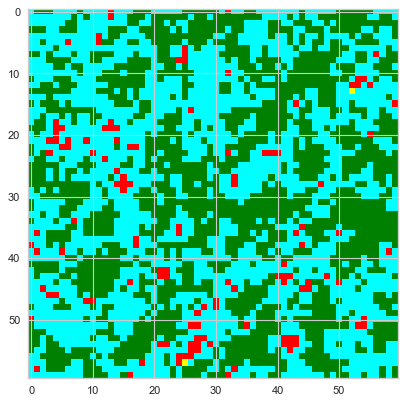

HF-2102_V2BB_1.h5_3
[3084  324    0   35   33    0]


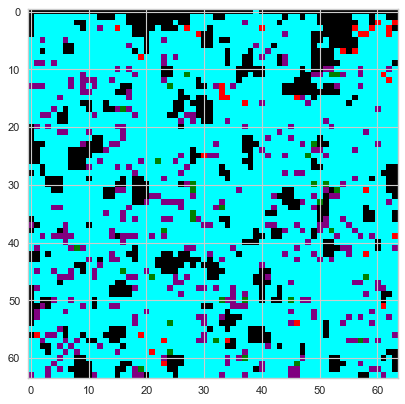

HF-2102_V3AM_1.h5_4
[ 597    0    0 2694    0    3]


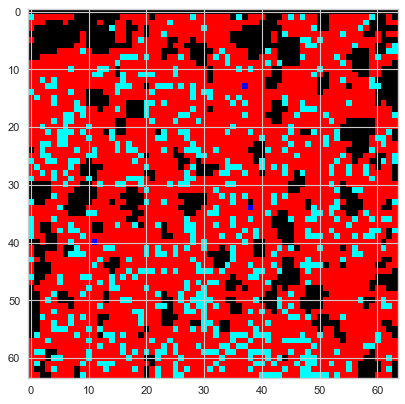

HF-2102_V3AM_2.h5_5
[ 642    1    0 2600    1   19]


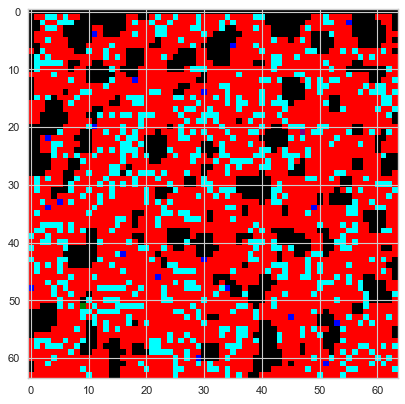

HF-2104_#5_1.h5_0
[1110    0    1 2340    0   31]


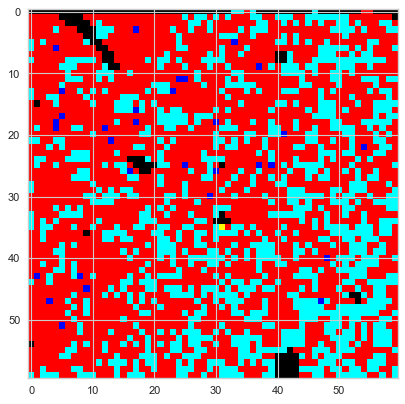

HF-2104_#9_1.h5_1
[ 726    1    0 2983   23  130]


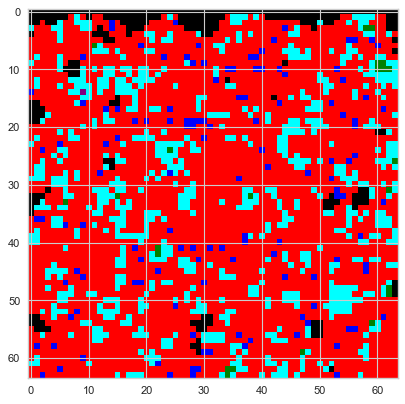

HF-2104_V1T_1.h5_2
[1039    0   88 2235   15   38]


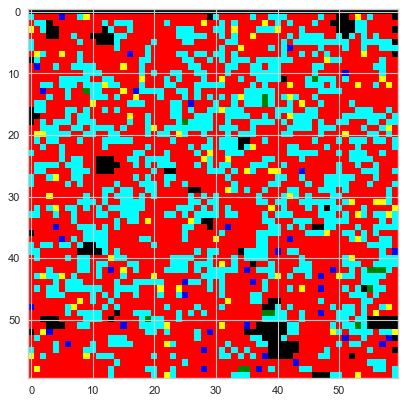

HF-2106_V3AM_1.h5_0
[1784   65    0 3002   28   18]


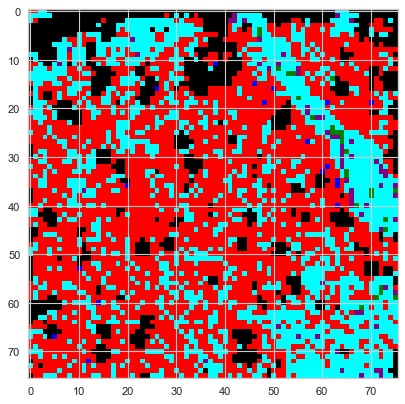

HF-2355_V2AM_1.h5_2
[3396  180    0  328   89    5]


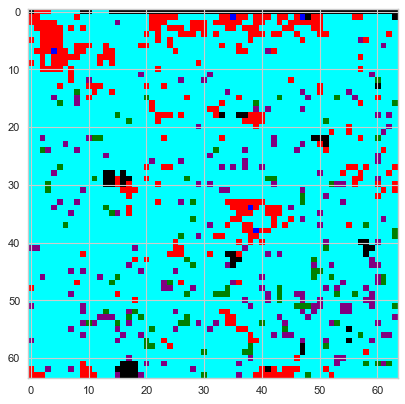

HF-2454_V1AT_1.h5_6
[2515   11    0 1116    2    0]


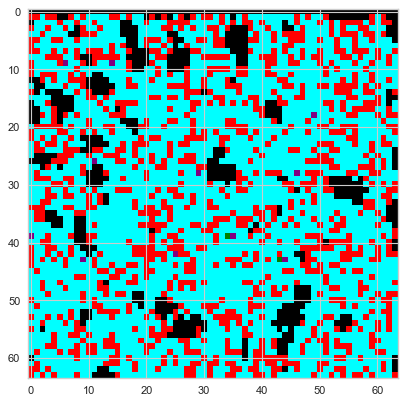

HF-2485_V1B_1.h5_3
[2057   24    0 1884   29   37]


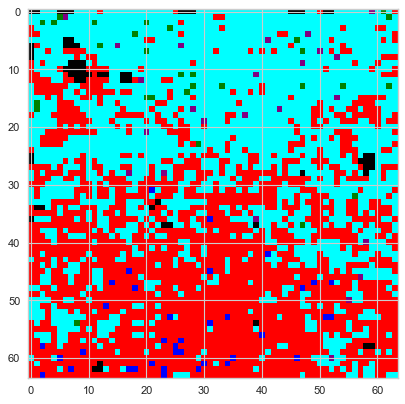

HF-2493_V1T_1.h5_1
[ 375    1   76 2114    0  108]


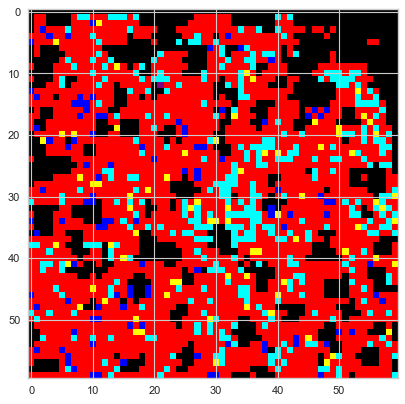

HF-2493_V1T_2.h5_2
[  6   0   0 951   0 764]


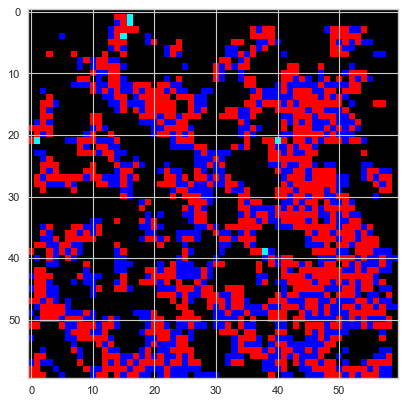

HF-2534_V2B_1.h5_2
[3449  324    0   20   55    0]


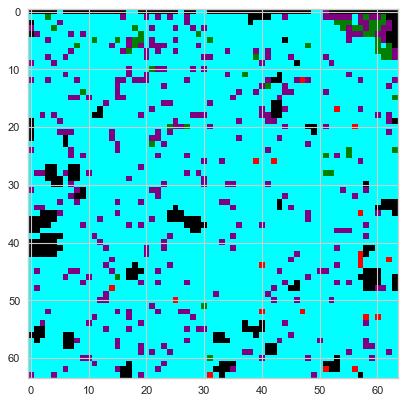

HF-2544_V1B_1.h5_3
[ 787    0   61 1364    5   13]


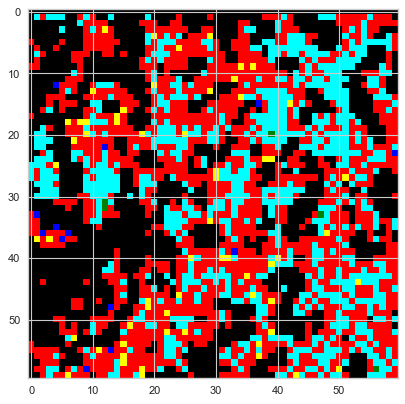

HF-2548_V1T_1.h5_7
[1783   19    0 2253   10   29]


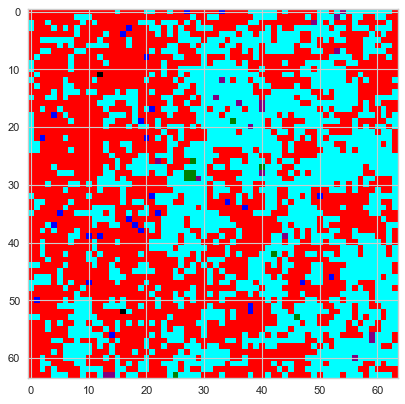

HF-2600_V1B_1.h5_4
[3271   42    0  568   51    0]


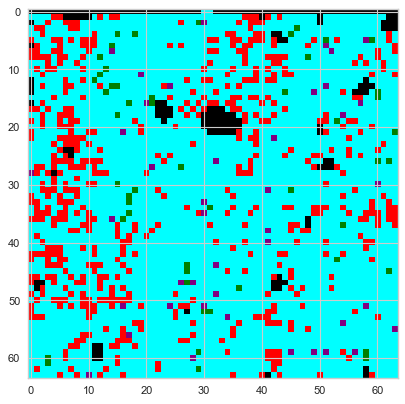

HF-2608_V1T_1.h5_5
[2672   28    0 1144   45    5]


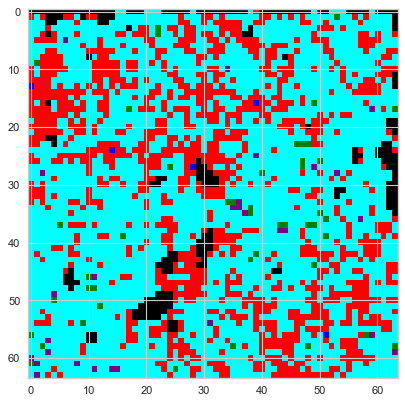

HF-2614_V1B_1.h5_3
[1881    0    4  118 1382    0]


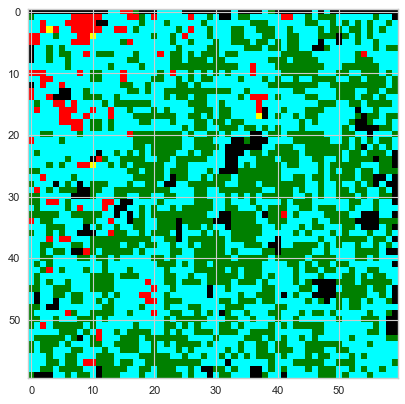

HF-2619_V1T_1.h5_6
[3542  182    0  237   65    0]


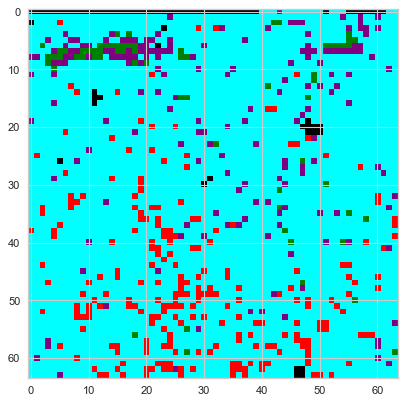

HF-2619_V4T_1.h5_7
[2090    0   20 1270  130    5]


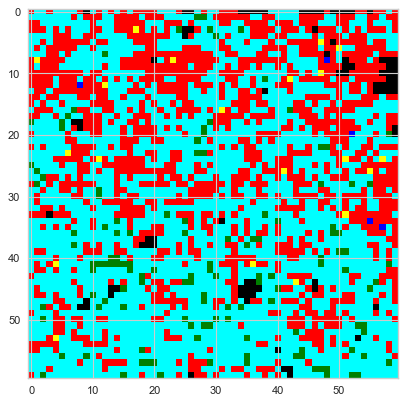

HF-2666_V2B_1.h5_8
[ 928    1    1 2685    1   17]


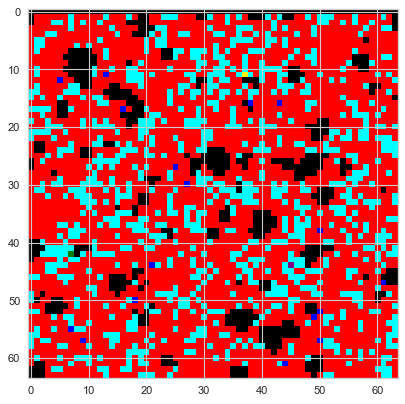

HF-2715_VIL_1.h5_8
[2820   60    0 1069   94    3]


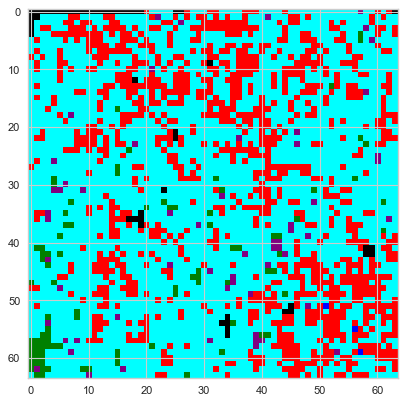

HF-2776_V2B_2.h5_5
[ 177    0    0 6253    0  870]


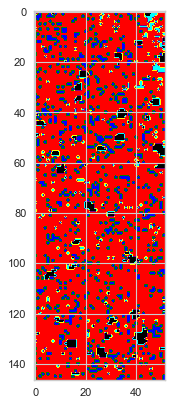

HF-2802_V3T_1.h5_9
[2013    0    3 1975    5    8]


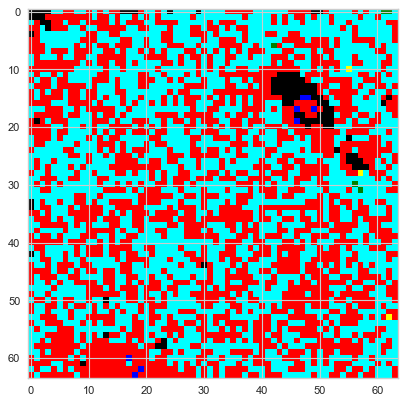

HF-2849_VIT2_1.h5_4
[ 276   35    0 1127    0   87]


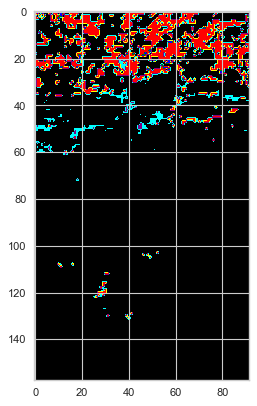

HF-2849_VIT2_1.h5_5
[1499  146    0 1848    0  137]


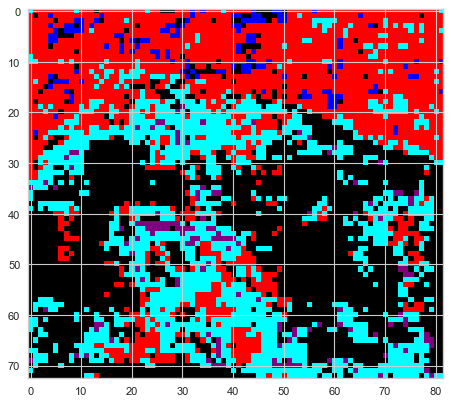

HF-2849_VIT2_2.h5_6
[1664    0   67 1905    3  199]


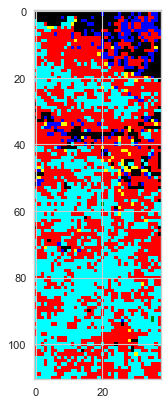

HF-2849_VIT_2_new2021.h5_7
[2555  488   22 2521   34   70]


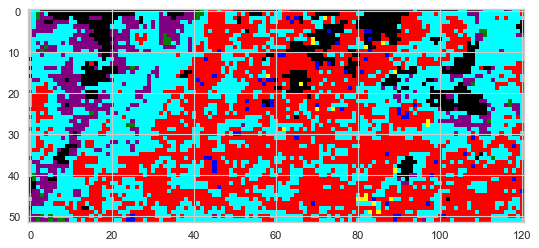

HF-2852_VIT_2_2.h5_8
[ 314    0    1 3319    0   32]


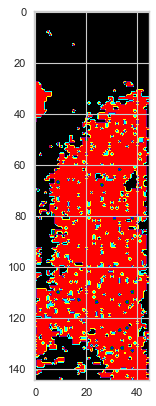

HF-2876_V1T_1.h5_10
[2823    0    7  136  475    1]


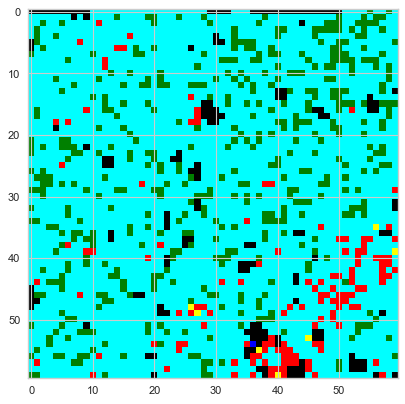

HF-2898_V1T_1.h5_11
[ 629    0    0 3077    1  308]


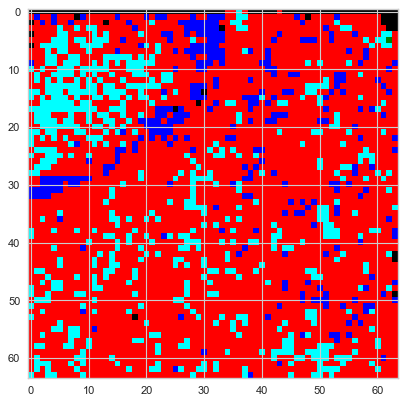

HF-3271_VIB_2.h5_7
[6303   33    0 5569    4  123]


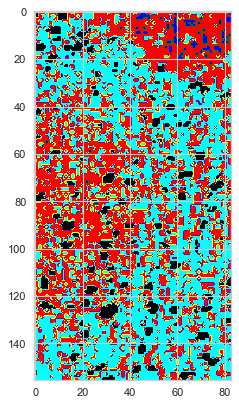

HF-3337_V3T_1.h5_8
[ 579    0    0 3351    1  103]


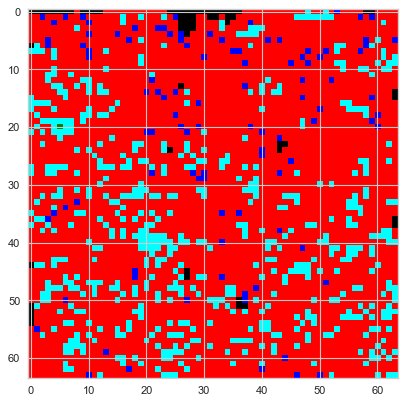

In [19]:
"""
Compute and save the surface map of each sample.
"""
   
# For each sample, display the surface map with the non-tumor spots as black.
for (sample, tumor, shape) in zip(samples, tumor_map, orig_shape):
    # If the sample is in the ignore list, skip it
    if sample[SAMPLE_DICT_NAME_KEY] in ignore:
        continue
        
    print(sample[SAMPLE_DICT_NAME_KEY])
    
    # Fill the predictions with 0; the tumor spots get their values replaced with the cluster ID (1 or larger)
    predict = np.zeros(tumor.shape, dtype=int)
    predict[tumor == 1] = 1 + model6.predict(sample[SAMPLE_DICT_DATA_KEY][tumor == 1])
    
    # Print the frequency of cluster predictions
    print(np.bincount(predict[tumor == 1]-1, minlength=6))

    # Bigger picture for better resolution
    plt.figure(figsize=(8, 6), dpi=80)
    
    # Use the cmap and norm defined in the beginning of the script
    plt.imshow(predict.reshape((shape[0],shape[1])), cmap = six_cmap, norm = six_norm)
    plt.savefig(SIX_CLUSTER_IMAGES_PATH+"lgm"+str(sample[SAMPLE_DICT_CLASS_ID_KEY])+"/"+sample[SAMPLE_DICT_NAME_KEY]+".png")
    plt.show()

In [20]:
# See how many spectra are within each cluster
print(np.bincount(model6.predict(data)))

[100416   2714   1171 127638  11000  10669]


In [21]:
del model6
gc.collect()

48041